In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor

In [2]:
df=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sub = test[['User_ID','Product_ID']]

In [3]:
df.shape,test.shape

((550068, 12), (233599, 11))

In [4]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [7]:
df.User_ID.nunique(), test.User_ID.nunique()

(5891, 5891)

In [8]:
df.Product_ID.nunique(), test.Product_ID.nunique()

(3631, 3491)

In [9]:
len(set(test['Product_ID'].tolist())-(set(df['Product_ID'].tolist())))

46

In [10]:
len(set(test['User_ID'].tolist())-(set(df['User_ID'].tolist())))

0

### Target Variable

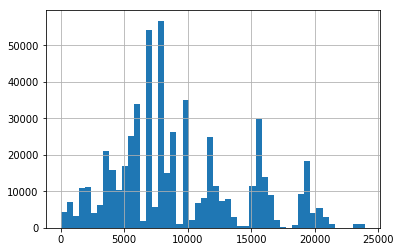

In [11]:
df.Purchase.hist(bins=50)

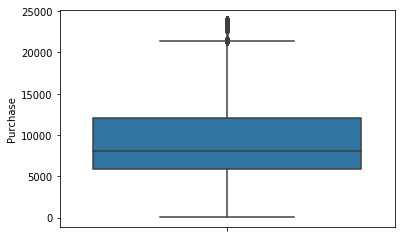

In [12]:
sns.boxplot(y=df.Purchase)

### Age

In [13]:
df.Age.value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

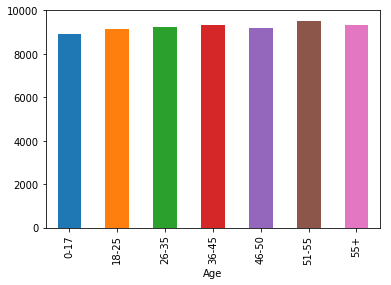

In [14]:
df.groupby('Age').Purchase.mean().plot(kind='bar')

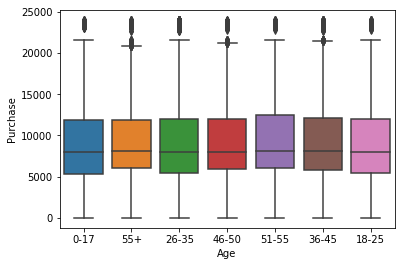

In [15]:
sns.boxplot(x=df.Age,y=df.Purchase)

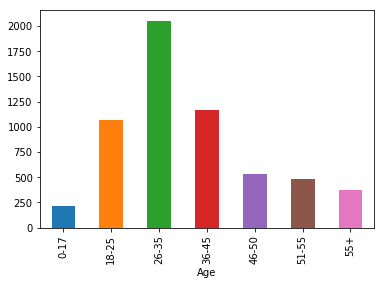

In [16]:
df.groupby(['Age']).User_ID.apply(lambda x :x.nunique()).plot(kind='bar')

### Gender

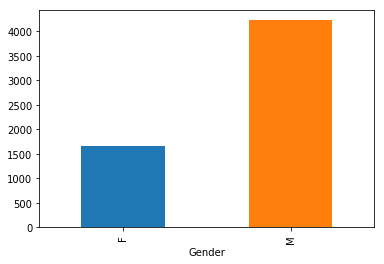

In [17]:
df.groupby(['Gender']).User_ID.apply(lambda x :x.nunique()).plot(kind='bar')

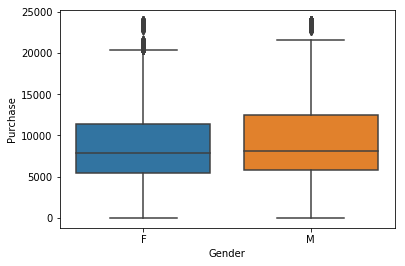

In [18]:
sns.boxplot(x=df.Gender,y=df.Purchase)

### City_Category

In [19]:
df.City_Category.value_counts()

B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

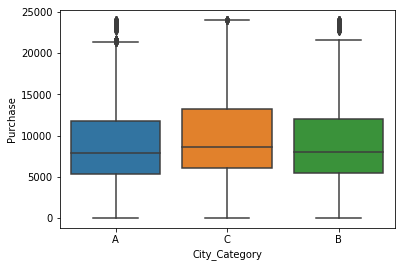

In [20]:
sns.boxplot(x=df.City_Category,y=df.Purchase)

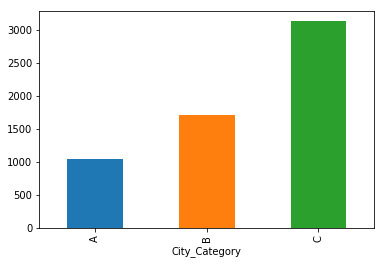

In [21]:
df.groupby(['City_Category']).User_ID.apply(lambda x :x.nunique()).plot(kind='bar')

### Stay_In_Current_City_Years

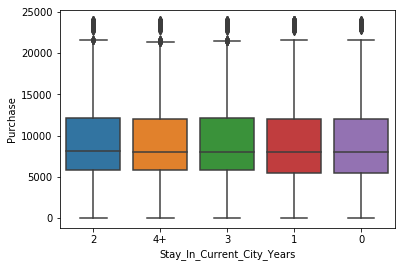

In [22]:
sns.boxplot(x=df.Stay_In_Current_City_Years,y=df.Purchase)

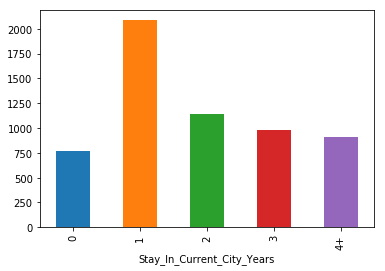

In [23]:
df.groupby(['Stay_In_Current_City_Years']).User_ID.apply(lambda x :x.nunique()).plot(kind='bar')

### Occupation

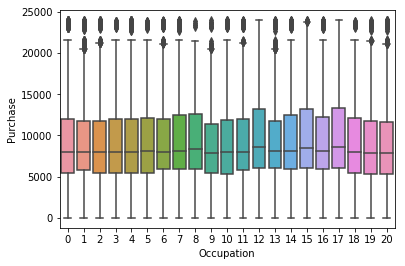

In [24]:
sns.boxplot(x=df.Occupation,y=df.Purchase)

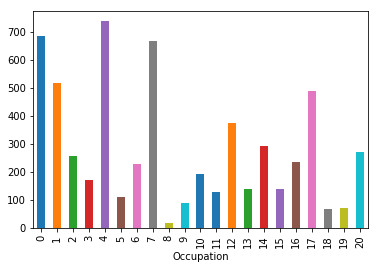

In [25]:
df.groupby(['Occupation']).User_ID.apply(lambda x :x.nunique()).plot(kind='bar')

### Marital_Status

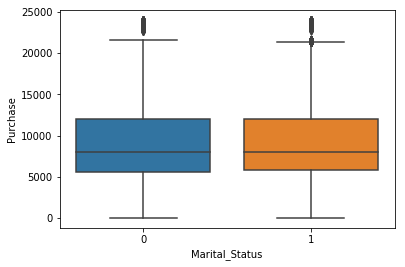

In [26]:
sns.boxplot(x=df.Marital_Status,y=df.Purchase)

### Product_Category_1

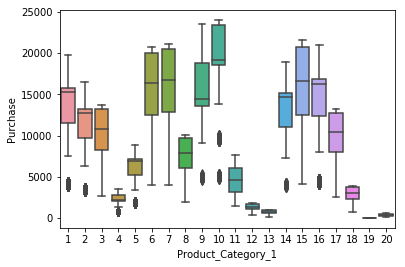

In [27]:
sns.boxplot(x=df.Product_Category_1,y=df.Purchase)

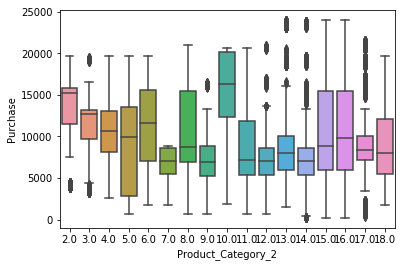

In [28]:
sns.boxplot(x=df.Product_Category_2,y=df.Purchase)

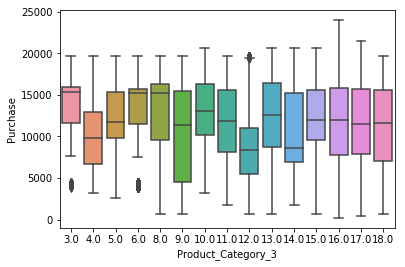

In [29]:
sns.boxplot(x=df.Product_Category_3,y=df.Purchase)

In [30]:
col_list=df.columns.tolist()

In [31]:
df['Flag']=1
test['Flag']=0

In [32]:
df_full=df.append(test,sort=False)

In [33]:
len(df_full)

783667

### Model 1

In [34]:
obj=['Product_ID','User_ID']
for f in df_full[obj]:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_full[f].values))
        df_full[f] = lbl.transform(list(df_full[f].values))

In [35]:
drop = list(set(col_list) - set(['Product_Category_1','Product_Category_2','Product_Category_3','City_Category','Purchase'])-set(obj))

In [36]:
drop

['Occupation', 'Marital_Status', 'Gender', 'Stay_In_Current_City_Years', 'Age']

In [37]:
def cleandata(data):
    data=data.drop(drop,axis=1)
    
    data.Product_Category_1.fillna(-999, inplace=True)
    data.Product_Category_2.fillna(-999, inplace=True)
    data.Product_Category_3.fillna(-999, inplace=True)
    
    data.Product_Category_1=data.Product_Category_1.astype('category')
    data.Product_Category_2=data.Product_Category_2.astype('category')  
    data.Product_Category_3=data.Product_Category_3.astype('category')    
    
    data=pd.get_dummies(data)
    
    return data

In [38]:
df_full1=cleandata(df_full)

In [39]:
y=df_full1[df_full1['Flag']==1]['Purchase'].reset_index(drop=True)

In [40]:
train=df_full1[df_full1['Flag']==1].drop('Purchase',1).reset_index(drop=True)
test=df_full1[df_full1['Flag']==0].drop('Purchase',1).reset_index(drop=True)

In [41]:
train.shape, test.shape

((550068, 60), (233599, 60))

In [42]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y= train_test_split(train, y, test_size=0.30, random_state=123)

In [43]:
feature=train.columns.tolist()

In [44]:
import gc
gc.collect()

59

In [45]:
param = {'objective' : 'reg:linear',
            'eta' : 0.1,
            'max_depth' : 10,
            'silent' : 1,
            'eval_metric' : "rmse",
            'min_child_weight' : 1,
            'nthread' : 16,
            'subsample' : 0.8,
            'colsample_bytree' : 0.8,
            'seed' : 123}

para = list(param.items())

xgtrain = xgb.DMatrix(train_x, train_y, feature_names=feature)
xgval = xgb.DMatrix(val_x, val_y, feature_names=feature)
xgtest = xgb.DMatrix(test, feature_names=feature)
    
watchlist = [ (xgtrain,'train'), (xgval, 'valid') ]
model = xgb.train(para, xgtrain, num_boost_round=3000, evals= watchlist, early_stopping_rounds=20, verbose_eval = 10)   
    
pred_Val_y = model.predict(xgtest)

[0]	train-rmse:9597.14	valid-rmse:9577.67
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[10]	train-rmse:4353.17	valid-rmse:4350.98
[20]	train-rmse:3022.32	valid-rmse:3046.47
[30]	train-rmse:2762.1	valid-rmse:2804.37
[40]	train-rmse:2705.29	valid-rmse:2755.99
[50]	train-rmse:2675.69	valid-rmse:2734.39
[60]	train-rmse:2652.42	valid-rmse:2719.77
[70]	train-rmse:2632.75	valid-rmse:2706.56
[80]	train-rmse:2615.79	valid-rmse:2696.04
[90]	train-rmse:2597.55	valid-rmse:2684.69
[100]	train-rmse:2579.15	valid-rmse:2673.87
[110]	train-rmse:2565.74	valid-rmse:2666.2
[120]	train-rmse:2549.24	valid-rmse:2656.41
[130]	train-rmse:2534.49	valid-rmse:2648.61
[140]	train-rmse:2521.41	valid-rmse:2641.45
[150]	train-rmse:2507.97	valid-rmse:2634.21
[160]	train-rmse:2493.94	valid-rmse:2626.43
[170]	train-rmse:2480.61	valid-rmse:2620.09
[180]	train-rmse:2469.38	valid-rmse:2614.28
[190]	train-rmse:2457.19	valid-r

In [47]:
feature=train.columns.tolist()

In [48]:
import gc
gc.collect()

0

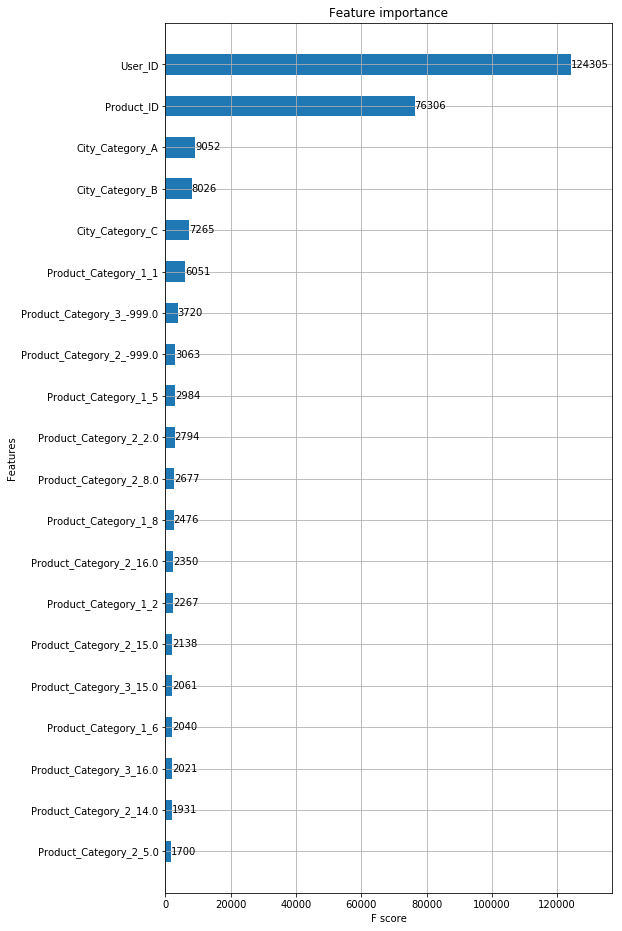

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

In [50]:
sub['Purchase1']=pred_Val_y

### Model 2

In [51]:
obj=['Product_ID','User_ID','Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years',]
for f in df_full[obj]:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_full[f].values))
        df_full[f] = lbl.transform(list(df_full[f].values))

In [52]:
y=df_full[df_full['Flag']==1]['Purchase'].reset_index(drop=True)
train1=df_full[df_full['Flag']==1].drop(['Flag'],1).reset_index(drop=True)
test1=df_full[df_full['Flag']==0].drop(['Flag'],1).reset_index(drop=True)

In [53]:
col=train1.columns.tolist()

In [54]:
col_dict=dict()

In [55]:
for col in col:
    p=train1.groupby(col).agg({'Purchase': ['mean','max','min'], 'User_ID' : 'count', 'Product_ID' : 'count'}).reset_index()
    p.columns = [col +''.join(x) for x in p.columns.ravel()]
    col_dict[col] = p

In [56]:
train1.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,684,0,0,10,0,2,0,3,NaN,NaN,8370.0
1,0,2406,0,0,10,0,2,0,1,6.0,14.0,15200.0
2,0,868,0,0,10,0,2,0,12,NaN,NaN,1422.0
3,0,844,0,0,10,0,2,0,12,14.0,NaN,1057.0
4,1,2769,1,6,16,2,4,0,8,NaN,NaN,7969.0


In [57]:
col_name='User_ID'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [58]:
col_name='Product_ID'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [59]:
col_name='Gender'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [60]:
col_name='Age'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [61]:
col_name='Occupation'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [62]:
col_name='City_Category'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [63]:
col_name='Stay_In_Current_City_Years'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [64]:
col_name='Marital_Status'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [65]:
col_name='Product_Category_1'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [66]:
col_name='Product_Category_2'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [67]:
col_name='Product_Category_3'
train1=train1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')
test1=test1.merge(col_dict[col_name],left_on=col_name,right_on=col_name+col_name,how='left')

In [68]:
y=train1['Purchase']

In [69]:
drop1=['Purchase','Product_Category_3Product_Category_3','Product_Category_2Product_Category_2','Product_Category_1Product_Category_1',
      'Marital_StatusMarital_Status','AgeAge','City_Category','Stay_In_Current_City_YearsStay_In_Current_City_Years',
       'OccupationOccupation','GenderGender','User_IDUser_ID','Product_IDProduct_ID']

In [70]:
train1=train1.drop(drop1,1)
test1=test1.drop(drop1,1)

In [71]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y= train_test_split(train1, y, test_size=0.30, random_state=123)

In [72]:
feature=train1.columns.tolist()
gc.collect()

196

In [73]:
param = {'objective' : 'reg:linear',
            'eta' : 0.1,
            'max_depth' : 10,
            'silent' : 1,
            'eval_metric' : "rmse",
            'min_child_weight' : 1,
            'nthread' : 16,
            'subsample' : 0.8,
            'colsample_bytree' : 0.8,
            'seed' : 1}

para = list(param.items())

xgtrain = xgb.DMatrix(train_x, train_y, feature_names=feature)
xgval = xgb.DMatrix(val_x, val_y, feature_names=feature)
xgtest = xgb.DMatrix(test1, feature_names=feature)
    
watchlist = [ (xgtrain,'train'), (xgval, 'valid') ]
model = xgb.train(para, xgtrain, num_boost_round=3000, evals= watchlist, early_stopping_rounds=20, verbose_eval = 10)   
    
pred_Val_y = model.predict(xgtest)

[0]	train-rmse:9560.09	valid-rmse:9541.17
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[10]	train-rmse:4054.14	valid-rmse:4070.38
[20]	train-rmse:2646.81	valid-rmse:2718.27
[30]	train-rmse:2378	valid-rmse:2492.42
[40]	train-rmse:2311.42	valid-rmse:2455.09
[50]	train-rmse:2279.85	valid-rmse:2445.76
[60]	train-rmse:2248.71	valid-rmse:2440.19
[70]	train-rmse:2230.25	valid-rmse:2437.63
[80]	train-rmse:2209.26	valid-rmse:2433.81
[90]	train-rmse:2190.24	valid-rmse:2431.12
[100]	train-rmse:2172.04	valid-rmse:2428.46
[110]	train-rmse:2152.89	valid-rmse:2426.37
[120]	train-rmse:2131.87	valid-rmse:2424.82
[130]	train-rmse:2114.21	valid-rmse:2423.83
[140]	train-rmse:2093.18	valid-rmse:2422.85
[150]	train-rmse:2077.02	valid-rmse:2422.26
[160]	train-rmse:2060	valid-rmse:2421.51
[170]	train-rmse:2043.03	valid-rmse:2420.49
[180]	train-rmse:2024.5	valid-rmse:2419.73
[190]	train-rmse:2008.06	valid-rmse:2

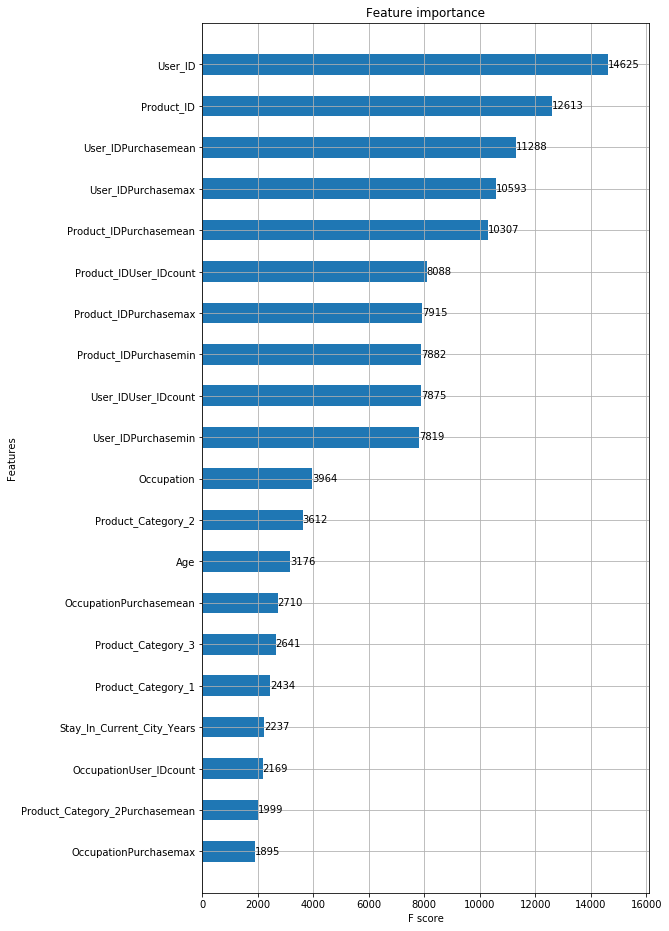

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

In [75]:
sub['Purchase2']=pred_Val_y

In [76]:
sub['Purchase2']=sub['Purchase2'].round(0)

In [77]:
sub['Purchase1']=sub['Purchase1'].round(0)

In [78]:
sub['Purchase']= 0.7*sub['Purchase2'] + 0.3*sub['Purchase1']

In [79]:
sub.head()

,User_ID,Product_ID,Purchase1,Purchase2,Purchase
0,1000004,P00128942,13443.0,16666.0,15699.1
1,1000009,P00113442,9594.0,11294.0,10784.0
2,1000010,P00288442,6575.0,6638.0,6619.1
3,1000010,P00145342,3216.0,2714.0,2864.6
4,1000011,P00053842,1984.0,1844.0,1886.0


In [80]:
sub.drop(['Purchase1','Purchase2'],1).to_csv('sub1.csv', index = False)

In [81]:
sub.drop(['Purchase1','Purchase'],1).to_csv('sub2.csv', index = False)